# Exercise: Sentinel-2, machine learning and in-silico experiments

This lesson is modified from [An Introduction to Cloud-Based Geospatial Analysis with Earth Engine and Geemap](https://geemap.org/workshops/AGU_2023/). Codes, annotation, and formatting are produced with assistant from Jupter AI using ChatGPT 3.5 Turbo and ChatGPT4o.

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/aselshall/eds/HEAD)

-----

In [1]:
# import ee
# #ee.Authenticate()
# ee.Initialize()

In [2]:
import ee

# Function to read the authorization code from a file
def read_auth_code(file_path):
    with open(file_path, 'r') as file:
        return file.read().strip()

# Read the authorization code
auth_code = read_auth_code('auth_code.txt')

# Authenticate using the authorization code
# Note: Use the 'ee.Authenticate()' method without parameters
ee.Authenticate()

# After calling ee.Authenticate(), you will need to manually input the 
# authorization code obtained from the 'auth_code.txt' file in the console
print("Please enter the authorization code from 'auth_code.txt' after running ee.Authenticate().")

# Initialize the Earth Engine
ee.Initialize()

Please enter the authorization code from 'auth_code.txt' after running ee.Authenticate().


In [3]:
import geemap
import pprint
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from concurrent.futures import ThreadPoolExecutor
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold



We can parallelize the code to speed up the execution by utilizing all available CPU cores in your machine. The code below will scale the number of workers dynamically based on the number of CPUs in your machine.


In [4]:
# Adjust the number of workers based on the available CPU cores
max_workers = os.cpu_count()
print(f'Available CPU cores: {os.cpu_count()}')
print(f'Max workers: {max_workers}')

Available CPU cores: 8
Max workers: 8


## Exercise

We aim to predict the Normalized Difference Chlorophyll Index (NDCI) using machine learning, with total nitrogen (TN), total phosphorus (TP), and turbidity as features. NDCI and turbidity will be derived from Sentinel-2 via Google Earth Engine (GEE), while TN and TP data will come from in-situ measurements. A synthetic dataset is used for TP and TN. The machine learning model will be used for in-silico experiments to estimate the likelihood of high NDCI based on TP and TN concentrations.

<div class="admonition alert alert-info">
    <p class="admonition-title" style="font-weight:bold">Note</p>
In machine learning, the terms "target variable" and "features" are more commonly used than "dependent variable" and "independent variables", respectively. In various literature, target variable - features can also be referred to as dependent variable - independent variables (statistics), state variable - decision variables (optimization), predicted variable - predictor variables (machine learning), outcome variable - input variables, outcome variable - drivers (environmental data science), response variable - explanatory variables (regression analysis), response variable - covariates, endogenous variable - exogenous variables (econometrics), etc.</div>

## 1. Data processing

### 1.1 Read TN and TP data points

TN and TP data will come from in-situ measurements. A synthetic dataset is used for TP and TN. 

In [5]:
#Select file
synthetic_data=True
if synthetic_data:
    file='synthetic_data_aoi_corr_estuarine'
else:
    file='TN_TP'

# Load the CSV file into a pandas DataFrame
df = pd.read_csv(file+'.csv')
df['date'] = pd.to_datetime(df['date'])

df

,longitude,latitude,date,TN,TP
0,-81.264838,25.885489,2019-02-04,8.148073,0.403715
1,-81.207286,25.853630,2019-02-08,5.281922,0.332332
2,-81.370581,25.729039,2019-02-12,1.169989,0.204646
3,-81.285316,25.785491,2019-02-21,8.170964,0.404525
4,-81.210103,25.714895,2019-03-08,4.147467,0.265021
...,...,...,...,...,...
95,-81.247479,25.891467,2023-08-09,6.463534,0.279415
96,-81.352622,25.727612,2023-09-02,4.318208,0.144700
97,-81.239949,25.735741,2023-09-10,7.491437,0.355962
98,-81.287473,25.745552,2023-10-14,9.265302,0.381369


### 1.2 Spectral indices derived from Sentinel-2 via GEE

NDCI and turbidity will be derived from Sentinel-2 via Google Earth Engine (GEE).

In [6]:
# Define the AOI using a polygon
aoi = ee.Geometry.Polygon([
  [
    [-81.4, 25.9],
    [-81.4, 25.7],
    [-81.2, 25.7],
    [-81.2, 25.9]
  ]
])

# Import Sentinel-2 image collection
sentinel2 = ee.ImageCollection('COPERNICUS/S2_HARMONIZED') \
.filterBounds(aoi) \
.filterDate('2019-01-01', '2023-12-31') \
.filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))

# Function to calculate NDCI and Turbidity
def calculate_indices(image):
    ndci = image.normalizedDifference(['B5', 'B4']).rename('NDCI')
    turbidity = image.select('B3').divide(image.select('B1')).multiply(8.93).subtract(6.39).rename('Turbidity')
    return image.addBands([ndci, turbidity])

# Apply the function to the image collection
processed_images = sentinel2.map(calculate_indices)

### 1.3 Extract spectral indices at TN and TP data points

<div class="admonition alert alert-info">
    <p class="admonition-title" style="font-weight:bold">Note</p>
Looping can be time-consuming. If you have good GEE coding skills, use GEE feature collection for CSV data to optimize efficiency, or just use parallel processing as shown in the code below.
</div>

In [7]:
# Function to process each row
def process_row(row, use_box):
    point = ee.Geometry.Point([row['longitude'], row['latitude']])
    if use_box:
        geometry = point.buffer(25).bounds()

    else:
        geometry = point
        
    date = ee.Date(row['date'].isoformat())
    start_date = date.advance(-30, 'day')
    end_date = date.advance(30, 'day')

    # Filter the images based on the date range and find the closest image to the given date
    filtered_images = processed_images.filterDate(start_date, end_date)
    closest_image = filtered_images.sort('system:time_start', opt_ascending=True).first()

    # Sample the median value within the geometry (point or box)
    sample = closest_image.reduceRegion(reducer=ee.Reducer.median(), geometry=geometry, scale=10).getInfo()

    # Check if the sample contains data
    if sample:
        timestamp = pd.to_datetime(closest_image.get('system:time_start').getInfo(), unit='ms').strftime('%Y-%m-%d')
        result = {
            'longitude': row['longitude'],
            'latitude': row['latitude'],
            'date': row['date'],
            'timestamp': timestamp,
            'TN': row['TN'],
            'TP': row['TP'],
            'Turbidity': sample.get('Turbidity'),
            'NDCI': sample.get('NDCI'),
        }
        return result

# Set the flag to use either point or box (set use_box to True for box, False for point)
use_box = True

# Initialize a ThreadPoolExecutor
# Parallelize the processing of each row using CPU cores
# Code snippet generated and annotated using ChatGPT4o
with ThreadPoolExecutor(max_workers=max_workers) as executor:
    # Submit tasks to the executor for each row in the DataFrame
    futures = [executor.submit(process_row, row, use_box) for _, row in df.iterrows()]
    # Collect results, filtering out any None values
    results = [future.result() for future in futures if future.result() is not None]

# Convert the results list to a pandas DataFrame
results_df = pd.DataFrame(results)

# Convert the 'date' and 'timestamp' columns to datetime if not already
results_df['date'] = pd.to_datetime(results_df['date'])
results_df['timestamp'] = pd.to_datetime(results_df['timestamp'])

# Sort the DataFrame by 'date' for TN and TP, and by 'timestamp' for Turbidity and NDCI
results_df.sort_values(by='date', inplace=True)
results_df.sort_values(by='timestamp', inplace=True)

# Interpolate the missing values in the 'Turbidity' and 'NDCI' columns
results_df['Turbidity'] = results_df['Turbidity'].interpolate()
results_df['NDCI'] = results_df['NDCI'].interpolate()

# Reset the index of the DataFrame
results_df.reset_index(drop=True, inplace=True)

# Display the results
display(results_df)

# Save the DataFrame to a CSV file
results_df.to_csv('results_data.csv', index=False)

,longitude,latitude,date,timestamp,TN,TP,Turbidity,NDCI
0,-81.264838,25.885489,2019-02-04,2019-01-06,8.148073,0.403715,-1.082422,0.244314
1,-81.207286,25.853630,2019-02-08,2019-01-11,5.281922,0.332332,-0.934880,0.126551
2,-81.370581,25.729039,2019-02-12,2019-01-14,1.169989,0.204646,1.045439,-0.128676
3,-81.285316,25.785491,2019-02-21,2019-01-29,8.170964,0.404525,-0.358404,0.253574
4,-81.210103,25.714895,2019-03-08,2019-02-08,4.147467,0.265021,1.482074,0.027836
...,...,...,...,...,...,...,...,...
95,-81.247479,25.891467,2023-08-09,2023-07-22,6.463534,0.279415,0.144146,0.163415
96,-81.352622,25.727612,2023-09-02,2023-08-06,4.318208,0.144700,2.519038,-0.033768
97,-81.239949,25.735741,2023-09-10,2023-08-26,7.491437,0.355962,-0.332415,0.239970
98,-81.287473,25.745552,2023-10-14,2023-09-15,9.265302,0.381369,-1.185305,0.266476


### 1.4 Plot features (TN, TP, and turbidity) and target variable (NDCI) 

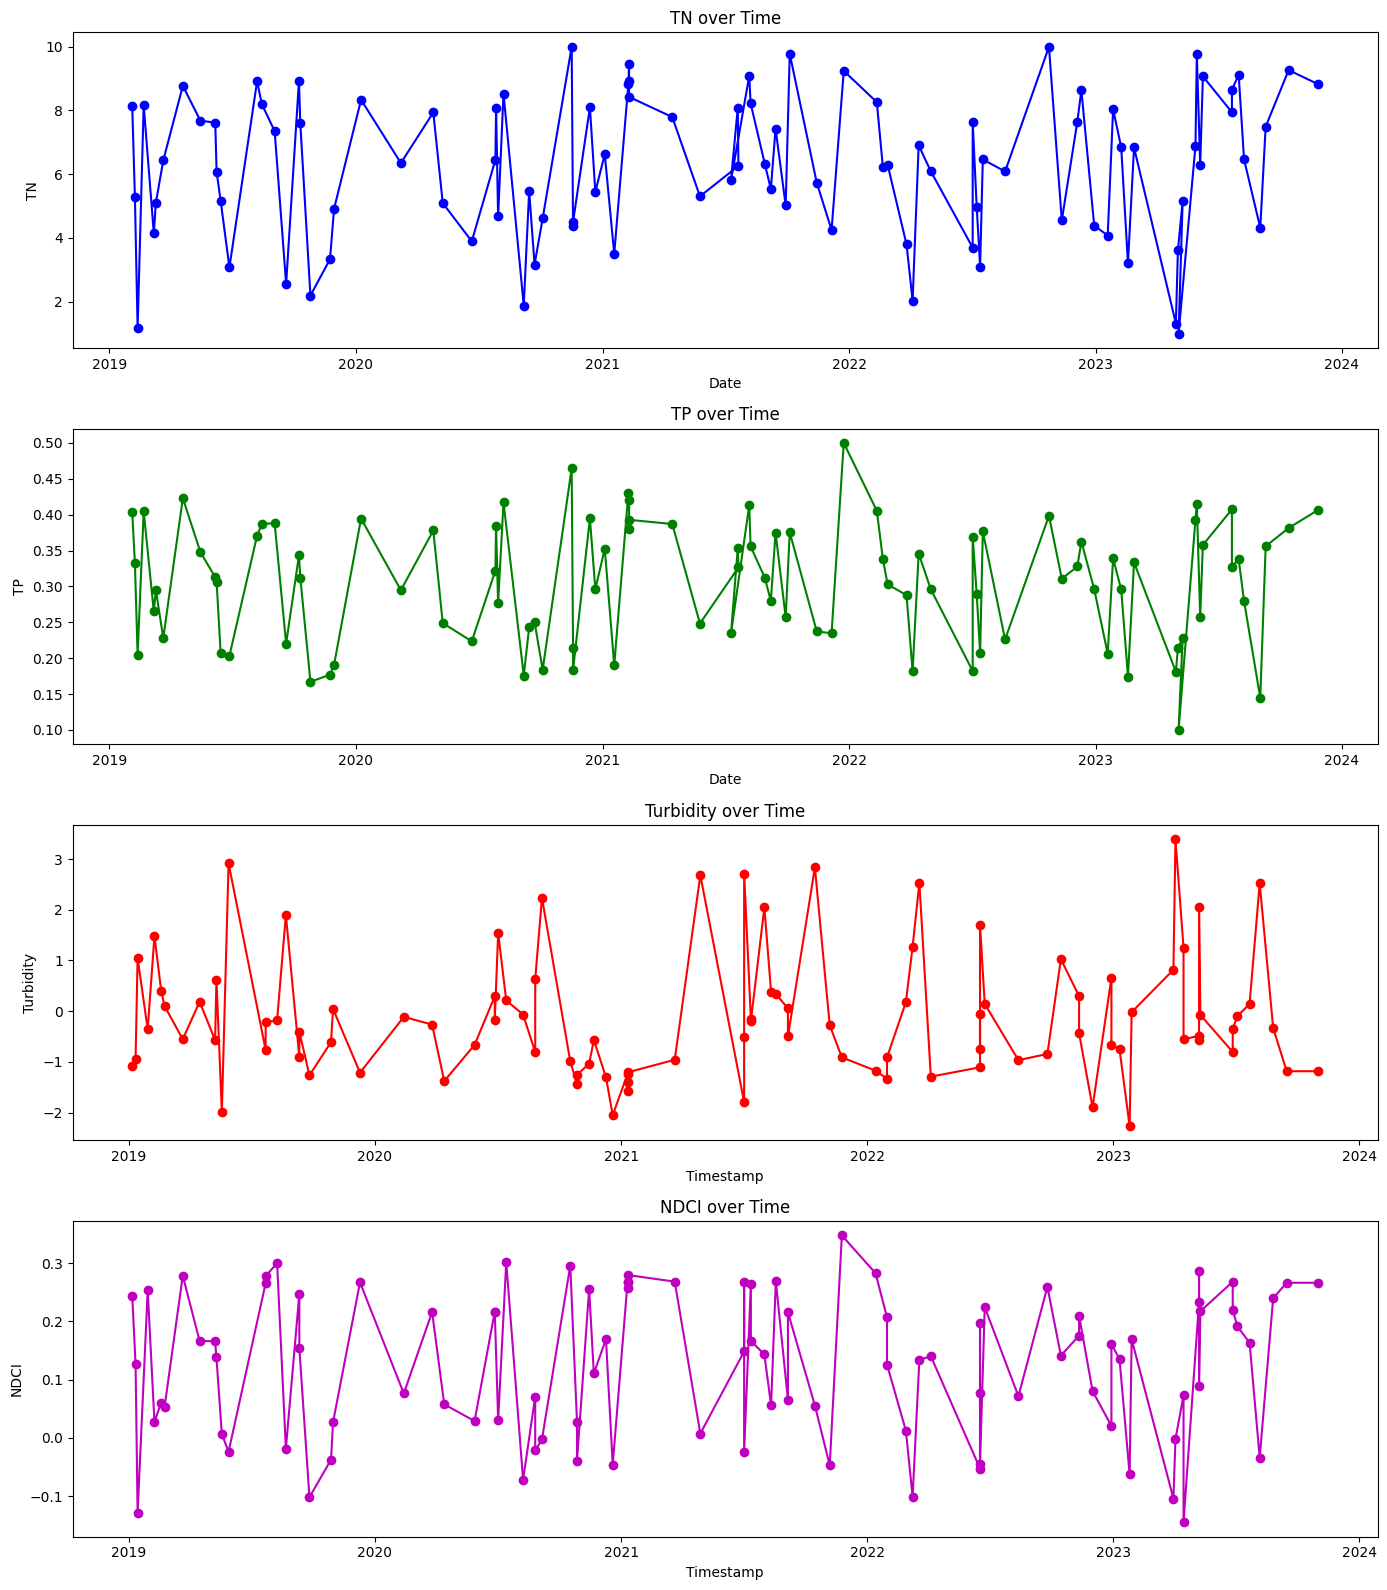

In [8]:
# Plotting the time series
plt.figure(figsize=(14, 16))

# Plot TN
plt.subplot(4, 1, 1)
plt.plot(results_df['date'], results_df['TN'], marker='o', linestyle='-', color='b')
plt.title('TN over Time')
plt.xlabel('Date')
plt.ylabel('TN')

# Plot TP
plt.subplot(4, 1, 2)
plt.plot(results_df['date'], results_df['TP'], marker='o', linestyle='-', color='g')
plt.title('TP over Time')
plt.xlabel('Date')
plt.ylabel('TP')

# Plot Turbidity
plt.subplot(4, 1, 3)
plt.plot(results_df['timestamp'], results_df['Turbidity'], marker='o', linestyle='-', color='r')
plt.title('Turbidity over Time')
plt.xlabel('Timestamp')
plt.ylabel('Turbidity')

# Plot NDCI
plt.subplot(4, 1, 4)
plt.plot(results_df['timestamp'], results_df['NDCI'], marker='o', linestyle='-', color='m')
plt.title('NDCI over Time')
plt.xlabel('Timestamp')
plt.ylabel('NDCI')

# Adjust layout
plt.tight_layout()
plt.show()


### 1.5 Correlation analysis

,TN,TP,Turbidity,NDCI
TN,1.000000,0.888440,-0.320723,0.930525
TP,0.888440,1.000000,-0.326276,0.953196
Turbidity,-0.320723,-0.326276,1.000000,-0.347834
NDCI,0.930525,0.953196,-0.347834,1.000000


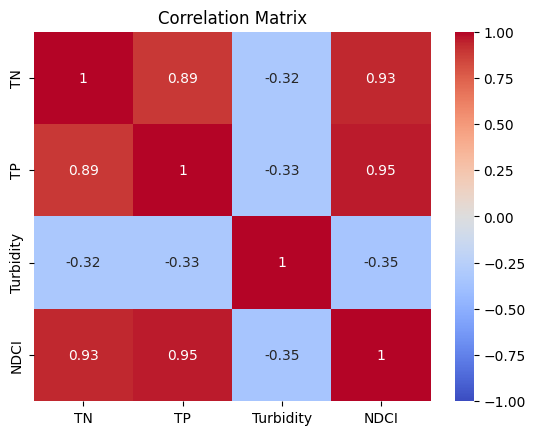

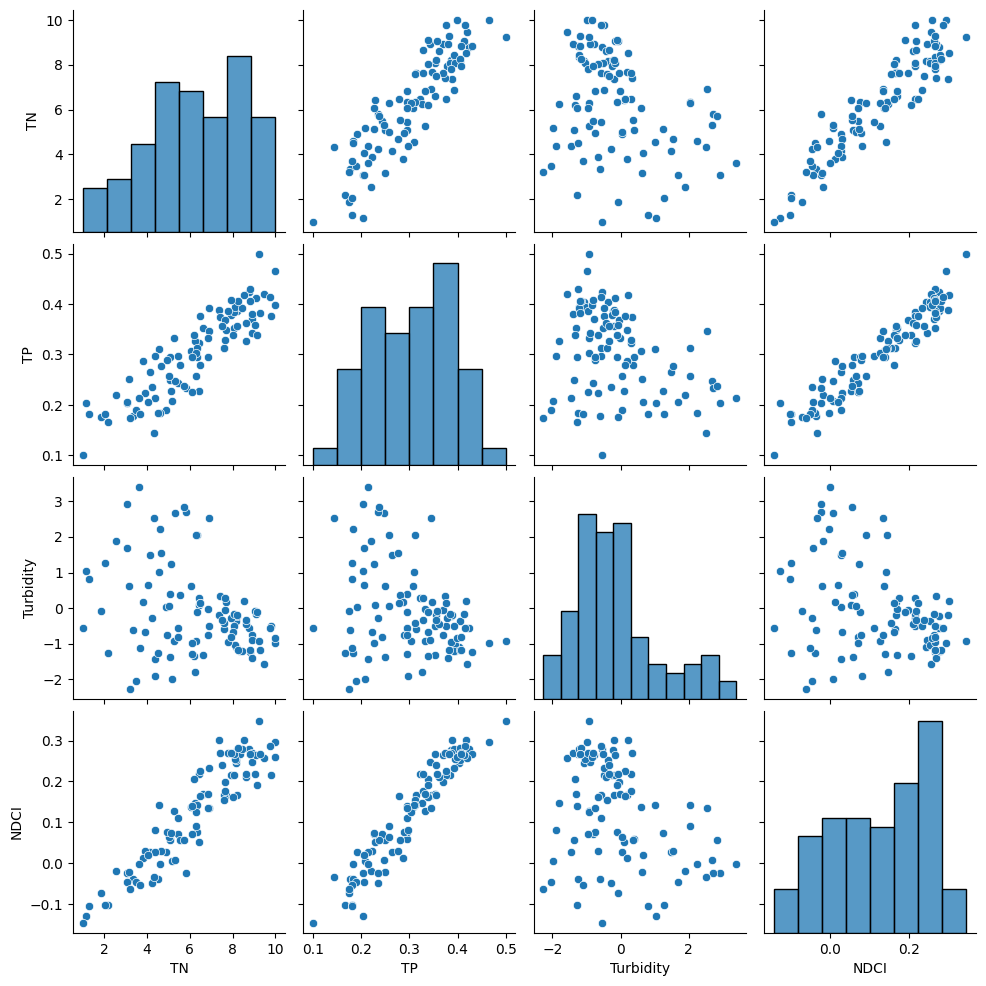

In [9]:
# Select relevant columns for analysis
analysis_df = results_df[['TN', 'TP', 'Turbidity', 'NDCI']]

# Perform correlation analysis on the relevant columns
correlation_matrix = analysis_df.corr()

# Display the correlation matrix
display(correlation_matrix)

# Plot Correlation Matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

# Pairplot
# diagonal axes show univariate distribution of each feature
# off-diagonal axes show scatterplots for pair of features
sns.pairplot(analysis_df)
plt.show()

## 2. Machine learning model to predict NDCI given drivers

NDCI estimates the concentration of chlorophyll in water bodies based on the difference in the absorption and reflectance of light by chlorophyll. NDCI is our target variable that we want to predict using total nitrogen (TN), total phosphorus (TP), and turbidity as our features.

### 2.1 Preprocessing

Before model training, we can check for missing values, dropping rows with missing values, and ensuring specific columns are numeric.

In [10]:
# Check for missing values
print("Missing values in each column:\n", results_df.isnull().sum())

# Drop rows with any missing values (you can also choose to fill them with appropriate values)
results_df = results_df.dropna()

# Ensure 'TN', 'TP', 'Turbidity', 'NDCI' columns are numeric
results_df[['TN', 'TP', 'Turbidity', 'NDCI']] = results_df[['TN', 'TP', 'Turbidity', 'NDCI']].apply(pd.to_numeric)


Missing values in each column:
 longitude    0
latitude     0
date         0
timestamp    0
TN           0
TP           0
Turbidity    0
NDCI         0
dtype: int64


### 2.2 Model training

Let us select few ML that can handle nonlinear relationships. We will train the model on 80% of the data and tested on the remaining 20% to evaluate its performance. For the model training we will selects features and a target variable, splits the data, few models as an example, evaluate model using MSE and $R^2$, plot actual vs predicted NDCI showing predictive accuracy. 
  
Plotting the model predictions with the actual test data can help in identifying any potential discrepancies or trends that the model might be missing.
   
To learn about machine learing (ML), you can check [these slide](https://aelshall.weebly.com/uploads/1/1/6/0/116033487/20210118introductionmachinelearning.pdf)

In [11]:
results_df

,longitude,latitude,date,timestamp,TN,TP,Turbidity,NDCI
0,-81.264838,25.885489,2019-02-04,2019-01-06,8.148073,0.403715,-1.082422,0.244314
1,-81.207286,25.853630,2019-02-08,2019-01-11,5.281922,0.332332,-0.934880,0.126551
2,-81.370581,25.729039,2019-02-12,2019-01-14,1.169989,0.204646,1.045439,-0.128676
3,-81.285316,25.785491,2019-02-21,2019-01-29,8.170964,0.404525,-0.358404,0.253574
4,-81.210103,25.714895,2019-03-08,2019-02-08,4.147467,0.265021,1.482074,0.027836
...,...,...,...,...,...,...,...,...
95,-81.247479,25.891467,2023-08-09,2023-07-22,6.463534,0.279415,0.144146,0.163415
96,-81.352622,25.727612,2023-09-02,2023-08-06,4.318208,0.144700,2.519038,-0.033768
97,-81.239949,25.735741,2023-09-10,2023-08-26,7.491437,0.355962,-0.332415,0.239970
98,-81.287473,25.745552,2023-10-14,2023-09-15,9.265302,0.381369,-1.185305,0.266476


Linear Regression:
  Mean Squared Error: 0.0003
  R² Score: 0.9704

Decision Tree Regressor:
  Mean Squared Error: 0.0009
  R² Score: 0.9167

Random Forest Regressor:
  Mean Squared Error: 0.0004
  R² Score: 0.9635

Best Model: Linear Regression (MSE 0.0003 - R^2 0.9704)


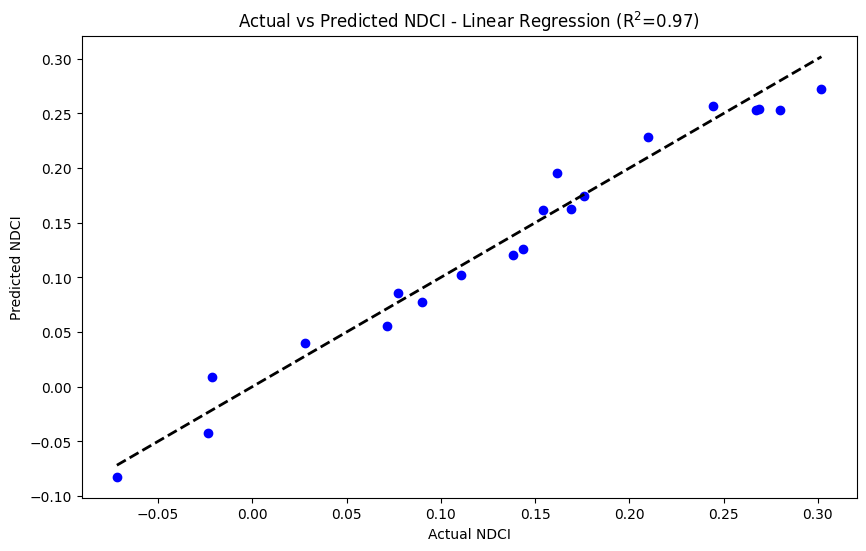

In [12]:
# Define the features and the target variable
features = ['TN', 'TP', 'Turbidity']
target = 'NDCI'

# Separate the features (X) and the target variable (y)
X = results_df[features]
y = results_df[target]

# Split the data into training and testing sets
# random_state=42: Ensures reproducibility of results
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
# Rich annotation by ChatGPT4o
# Define the models to be tested
models = {
    # Linear Regression
    # Strengths: Simple to understand and implement, works well for linear relationships.
    # Best Use: Linear relationships.
    # Parameters:
    #   - No hyperparameters need to be set for basic Linear Regression.
    'Linear Regression': LinearRegression(),

    # Decision Tree Regressor
    # Strengths: Captures non-linear patterns, easy to interpret and visualize.
    # Best Use: Capturing non-linear patterns.
    # Parameters:
    #   - random_state=42: Ensures reproducibility of results.
    'Decision Tree Regressor': DecisionTreeRegressor(random_state=42),

    # Random Forest Regressor
    # Strengths: Handles complex non-linear relationships, robust to outliers, works well with high-dimensional data.
    # Best Use: Complex non-linear relationships, handling outliers, and high-dimensional spaces.
    # Parameters:
    #   - n_estimators=100: Number of trees in the forest, more trees generally improve performance.
    #   - random_state=42: Ensures reproducibility of results.
    'Random Forest Regressor': RandomForestRegressor(n_estimators=100, random_state=42),
}

# Train and evaluate each model
model_results = {}
for model_name, model in models.items():
    # Train the model on the training data
    model.fit(X_train, y_train)
    
    # Make predictions on the test data
    y_pred = model.predict(X_test)
    
    # Calculate the mean squared error and R² to evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Store the results
    model_results[model_name] = {'model': model, 'y_pred': y_pred, 'mse': mse, 'r2': r2}
    
    # Print the evaluation metrics
    print(f"{model_name}:\n  Mean Squared Error: {mse:.4f}\n  R² Score: {r2:.4f}\n")

# Select the best model based on the lowest MSE
best_model_name = min(model_results, key=lambda x: model_results[x]['mse'])
best_model = model_results[best_model_name]['model']
best_model_mse = model_results[best_model_name]['mse']
best_model_r2 = model_results[best_model_name]['r2']

# Print the best model with its MSE and R^2
print(f"Best Model: {best_model_name} (MSE {best_model_mse:.4f} - R^2 {best_model_r2:.4f})")

# Use the best model for further analysis
model = best_model

# Make predictions with the best model on the test data
y_pred_test = model.predict(X_test)

# Plotting the actual vs predicted NDCI along with R^2 for the testing period
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual NDCI')
plt.ylabel('Predicted NDCI')
plt.title(f'Actual vs Predicted NDCI - {best_model_name} (R$^2$={best_model_r2:.2f})')
plt.show()

### 2.3 Ensemble prediction with credible intervals

Let us use k-fold cross-validation to create multiple training subsets and averages the predictions from each fold to generate ensemble predictions.  A K-fold cross-validation object is initialized to split the data into training and validation sets multiple times (in this case, 5 splits). The mean prediction and standard deviation across all folds for each model is calculated. The credible interval (mean ± 2.58 * standard deviation) along with ensemble mean prediction are plotted to represent the range and mean of the ensemble predictions. Credible intervals provide a visual representation of the uncertainty in the predictions. 

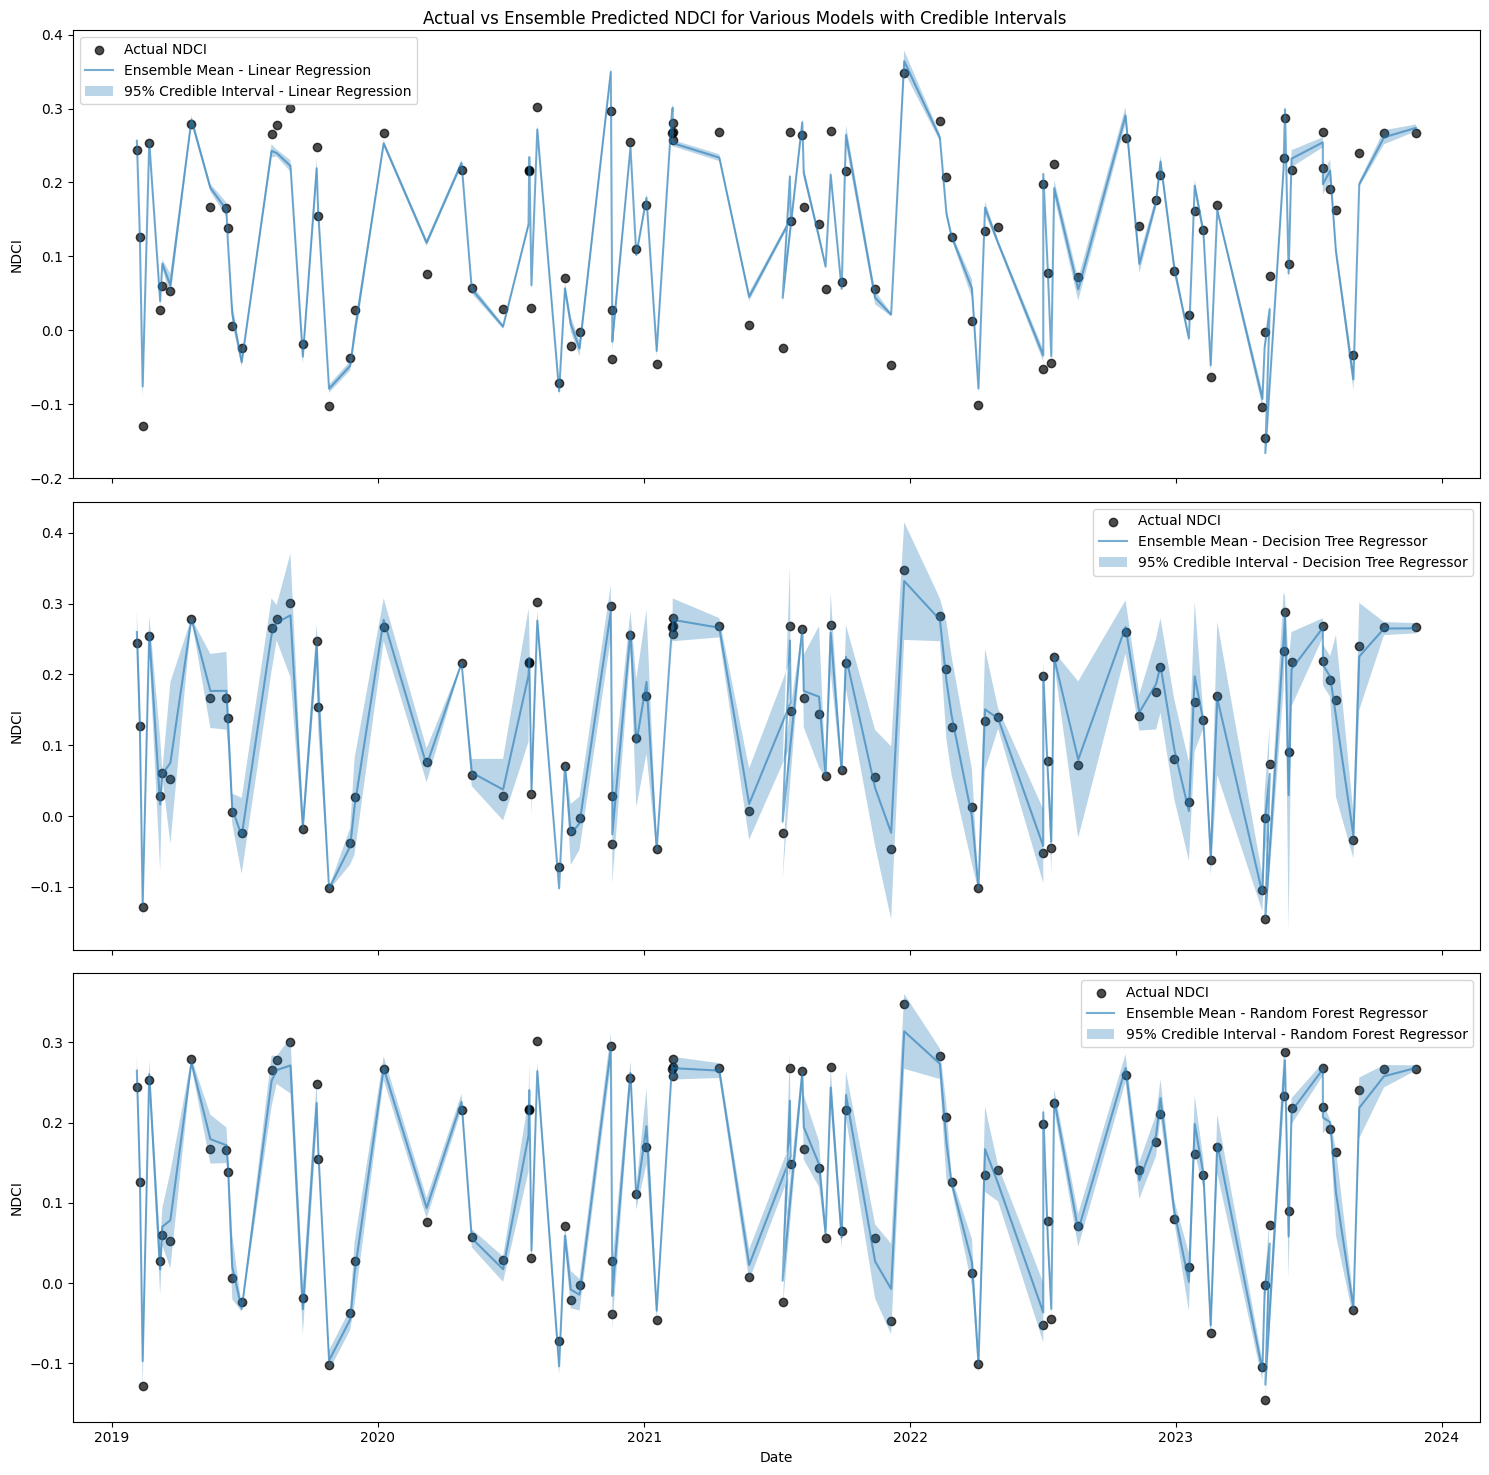

In [13]:
import matplotlib.pyplot as plt

# Define the features and the target variable
features = ['TN', 'TP', 'Turbidity']
target = 'NDCI'

# Separate the features (X) and the target variable (y)
X = results_df[features]
y = results_df[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree Regressor': DecisionTreeRegressor(random_state=42),
    'Random Forest Regressor': RandomForestRegressor(n_estimators=100, random_state=42),
}

# Number of splits for cross-validation
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Store predictions from each fold for each model
fold_predictions = {model_name: np.zeros((n_splits, len(results_df))) for model_name in models.keys()}

for model_name, model in models.items():
    for i, (train_index, _) in enumerate(kf.split(X_train)):
        X_train_fold, y_train_fold = X_train.iloc[train_index], y_train.iloc[train_index]
        model.fit(X_train_fold, y_train_fold)
        fold_predictions[model_name][i, :] = model.predict(results_df[features])

# Calculate the ensemble mean and standard deviation for each model
ensemble_means = {model_name: fold_predictions[model_name].mean(axis=0) for model_name in models.keys()}
ensemble_stds = {model_name: fold_predictions[model_name].std(axis=0) for model_name in models.keys()}

# Plotting the actual vs predicted NDCI for the testing period with credible intervals in subplots
fig, axes = plt.subplots(len(models), 1, figsize=(15, 15), sharex=True)

# Scatter plot for actual NDCI values in each subplot
for ax, model_name in zip(axes, models.keys()):
    ax.scatter(results_df['date'], results_df[target], label='Actual NDCI', color='black', alpha=0.7)
    std_pred = ensemble_stds[model_name]
    mean_pred = ensemble_means[model_name]
    
    ax.plot(results_df['date'], mean_pred, label=f'Ensemble Mean - {model_name}', alpha=0.6)
    ax.fill_between(results_df['date'], mean_pred - 2.58*std_pred, 
                     mean_pred + 2.58*std_pred, alpha=0.3, label=f'95% Credible Interval - {model_name}')
    ax.set_ylabel('NDCI')
    ax.legend()

axes[-1].set_xlabel('Date')
fig.suptitle('Actual vs Ensemble Predicted NDCI for Various Models with Credible Intervals')
plt.tight_layout()

# Save the figure
plt.savefig('actual_vs_ensemble_predicted_ndci_with_intervals_subplots.png')

plt.show()

In [14]:
# Define the features and the target variable
features = ['TN', 'TP', 'Turbidity']
target = 'NDCI'

# Separate the features (X) and the target variable (y)
X = results_df[features]
y = results_df[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree Regressor': DecisionTreeRegressor(random_state=42),
    'Random Forest Regressor': RandomForestRegressor(n_estimators=100, random_state=42),
}

# Number of splits for cross-validation
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Store predictions from each fold for each model
fold_predictions = {model_name: [] for model_name in models.keys()}

for model_name, model in models.items():
    for train_index, val_index in kf.split(X_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
        model.fit(X_train_fold, y_train_fold)
        fold_predictions[model_name].append(model.predict(X_test))

# Convert fold predictions to arrays
fold_predictions = {model_name: np.array(preds) for model_name, preds in fold_predictions.items()}

# Calculate the ensemble mean and standard deviation for each model
ensemble_means = {model_name: fold_preds.mean(axis=0) for model_name, fold_preds in fold_predictions.items()}
ensemble_stds = {model_name: fold_preds.std(axis=0) for model_name, fold_preds in fold_predictions.items()}

# Calculate KIC for each model
kics = {}
n = len(y_test)
for model_name in models.keys():
    mse = np.mean([mean_squared_error(y_test, pred) for pred in fold_predictions[model_name]])
    kics[model_name] = n * np.log(mse) + 2 * models[model_name].get_params().__len__()

# Calculate model weights
min_kic = min(kics.values())
model_weights = {model_name: np.exp(-0.5 * (kic - min_kic)) for model_name, kic in kics.items()}
weight_sum = sum(model_weights.values())
model_weights = {model_name: weight / weight_sum for model_name, weight in model_weights.items()}

# Create ensemble prediction
ensemble_prediction = np.sum([model_weights[model_name] * ensemble_means[model_name] 
                              for model_name in models.keys()], axis=0)




## 3. In-silico experiments
We can perform in-silico experiments to understand the impacts of different variables (TN, TP, Turbidity) on the probabilities of NDCI using the machine learning model that we developed. This can help us to analyze the relationships between these variables and can support decisions.

### 3.1 Sensitivity analysis (SA)
To understand the isolated impact of each feature, SA varies one feature at a time within 2 standard deviations of its mean while holding other features constant at their mean values. It is useful to do this analysis for more than one model. This code defines two machine learning models (Linear Regression and Random Forest) and conducts sensitivity analysis. The code then plots the sensitivity analysis results for each model, showing how changes in features affect the NDCI probability. 


<div class="admonition alert alert-info">
    <p class="admonition-title" style="font-weight:bold">Note</p>
The method of varying one feature at a time is simple but lacks capturing feature interactions. Global sensitivity analysis methods like Sobol analysis evaluates individual and combined feature influences, which can help to identify key drivers of model output and feature importance.
</div>

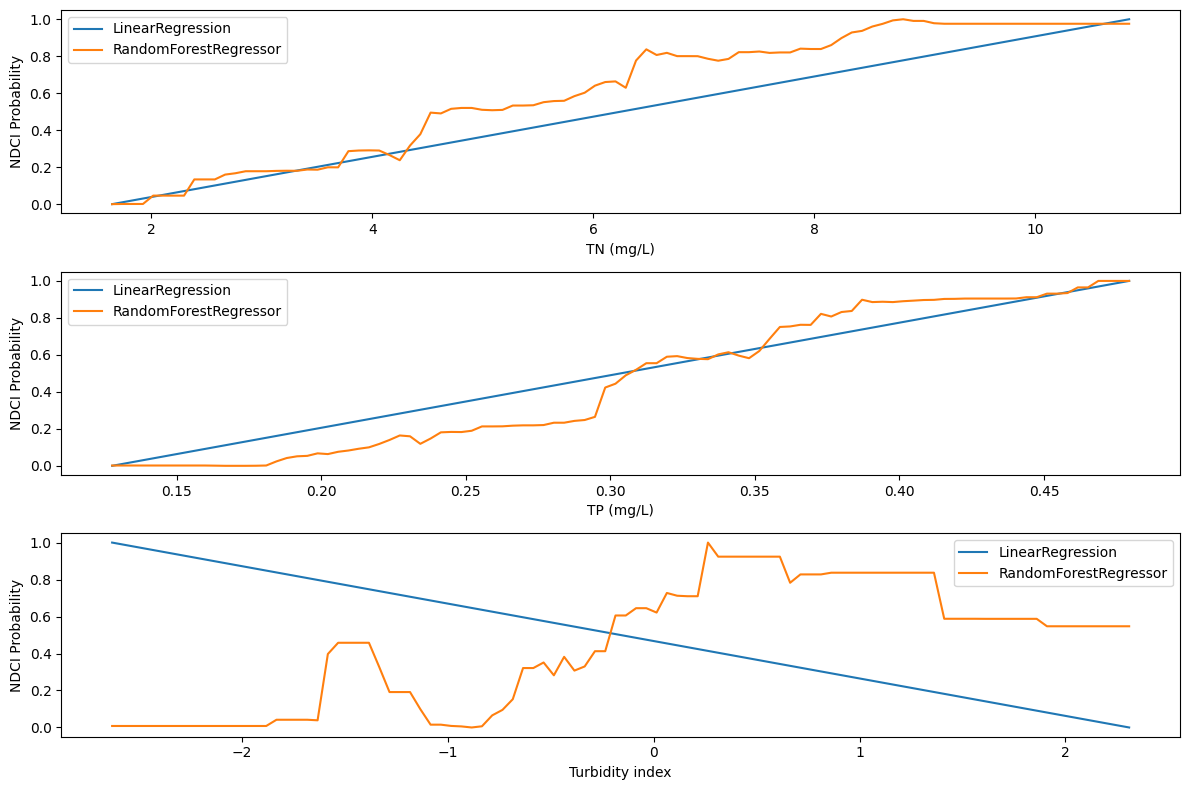

In [15]:
# Most of this code is genetated by ChatGPT 3.5 Turbo
# Define the models
models = [LinearRegression(), 
         RandomForestRegressor(n_estimators=100, random_state=42)]

# Function to normalize predictions to [0, 1] range
def normalize_predictions(predictions):
    min_pred = np.min(predictions)
    max_pred = np.max(predictions)
    normalized_preds = (predictions - min_pred) / (max_pred - min_pred)
    return normalized_preds

# Create a function to perform sensitivity analysis by varying one feature at a time
def sensitivity_analysis(model, X_train, feature_name, num_points=100):
    mean_values = X_train.mean()  # Annual mean values for all features
    std_values = X_train.std()  # Standard deviation for all features

    # Generate values for the feature to be varied
    feature_values = np.linspace(mean_values[feature_name] - 2 * std_values[feature_name],
                                 mean_values[feature_name] + 2 * std_values[feature_name],
                                 num_points)
    
    # Create a DataFrame to hold the varied feature values and the mean values for other features
    # You can also do mean value per year to study seasonal effect but this will make the code more complicated
    sensitivity_df = pd.DataFrame({feature_name: feature_values})
    for col in X_train.columns:
        if col != feature_name:
            sensitivity_df[col] = mean_values[col]

    # Fit the model with training data before making predictions
    model.fit(X_train, y_train)
    
    # Ensure the columns are in the same order as the training set
    sensitivity_df = sensitivity_df[X_train.columns]

    # Predict NDCI values using the model for the varied feature values
    predictions = model.predict(sensitivity_df)
    
    # Normalize predictions to the [0, 1] range to treat them as probabilities
    # Note this is not rigorous and a probabilisic estimates are needed
    probabilities = normalize_predictions(predictions)

    return feature_values, probabilities

# Perform sensitivity analysis for each feature with each model
sensitivity_results = {model.__class__.__name__: {} for model in models}

# Perform sensitivity analysis for each feature with each model
# Initialize a dictionary to store sensitivity analysis results, where:
# - Key: Model class name (obtained using __class__.__name__)
# - Value: An empty dictionary to hold sensitivity analysis results for each feature
# Note we are using "model.__class__.__name__" instead of just "model" 
# for getting the model name without its parameters for plotting
sensitivity_results = {model.__class__.__name__: {} for model in models}
for model in models:
    for feature in features:
        feature_values, probabilities = sensitivity_analysis(model, X_train, feature)
        sensitivity_results[model.__class__.__name__][feature] = (feature_values, probabilities)

# Plot the sensitivity analysis results for each model
plt.figure(figsize=(12, 8))

for i, feature in enumerate(features, 1):
    plt.subplot(3, 1, i)
    for model_name, model_results in sensitivity_results.items():
        plt.plot(model_results[feature][0], model_results[feature][1], label=f'{model_name}')
    
    plt.ylabel('NDCI Probability')
    plt.legend()
    
    if i <= 2:
        plt.xlabel(f'{feature} (mg/L)')
    else:
        plt.xlabel(f'{feature} index')

plt.tight_layout()
plt.show()

### 3.2 NDCI probability as a function of TN and TP

We can now visualize the NDCI probability as a function of TN and TPconcentrations using a Random Forest Regression model. The code achieves this by training a Random Forest Regressor model on the given dataset, predicting NDCI probabilities for various combinations of TN and TP values, normalizing these probabilities, and  plotting a contour of how NDCI probability varies with changes in TN and TP levels. This can help us to understand how nutrient concentrations (TN, TP) can affect chlorophyll content (NDCI).

In [17]:
Run = False  #Change to True to run this code
if Run:
    # Define the features and the target variable
    features = ['TN', 'TP', 'Turbidity']
    target = 'NDCI'
    
    # Separate the features (X) and the target variable (y)
    X = results_df[features]
    y = results_df[target]
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Initialize the Random Forest Regressor model
    #model= LinearRegression()
    #model= DecisionTreeRegressor(random_state=42)
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    # Define a grid of values for TN and TP
    tn_values = np.linspace(X_train['TN'].min(), X_train['TN'].max(), 100)
    tp_values = np.linspace(X_train['TP'].min(), X_train['TP'].max(), 100)
    
    # Create a meshgrid of TN and TP values
    TN, TP = np.meshgrid(tn_values, tp_values)
    turbidity_mean = X_train['Turbidity'].mean()
    
    # Predict NDCI probabilities for each combination of TN and TP
    NDCI_prob = np.zeros_like(TN)
    predictions = []
    
    for i in range(TN.shape[0]):
        for j in range(TN.shape[1]):
            sample = pd.DataFrame({'TN': [TN[i, j]], 'TP': [TP[i, j]], 'Turbidity': [turbidity_mean]})
            pred = model.predict(sample)[0]
            predictions.append(pred)
            NDCI_prob[i, j] = pred
    
    # Normalize the NDCI probabilities to [0, 1]
    NDCI_prob = (NDCI_prob - np.min(predictions)) / (np.max(predictions) - np.min(predictions))
    
    # Save TN, TP, NDCI_prob arrays
    np.save('TN.npy', TN)
    np.save('TP.npy', TP)
    np.save('NDCI_prob.npy', NDCI_prob)

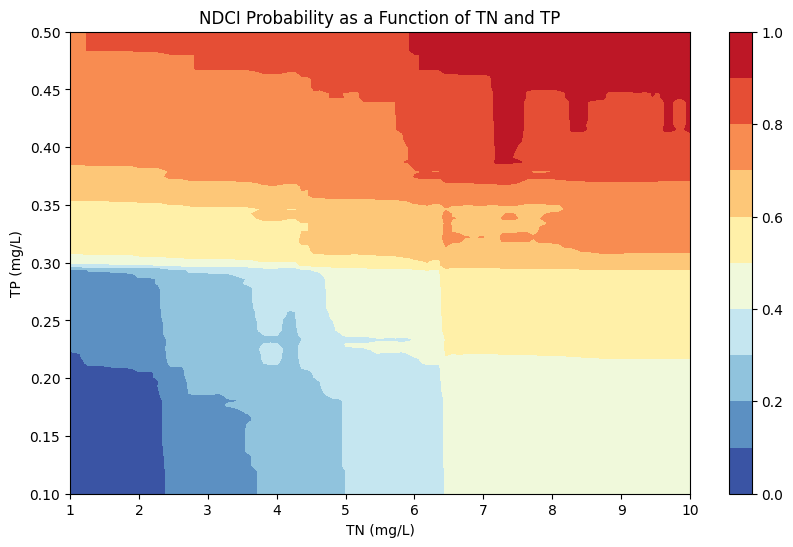

In [19]:
# Load TN, TP, NDCI_prob arrays
TN = np.load('TN.npy')
TP = np.load('TP.npy')
NDCI_prob = np.load('NDCI_prob.npy')

# Plot the contour plot
plt.figure(figsize=(10, 6))
contour = plt.contourf(TN, TP, NDCI_prob, levels=10, cmap='RdYlBu_r')
plt.colorbar(contour)
plt.xlabel('TN (mg/L)')
plt.ylabel('TP (mg/L)')
plt.title('NDCI Probability as a Function of TN and TP')
plt.show()